In [2]:
%pylab inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt # to generate plots
import xarray as xr
import pandas as pd
import scipy.interpolate
import scipy.ndimage
from scipy import stats
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker
from glob import glob as gb
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)
!pwd

Populating the interactive namespace from numpy and matplotlib
netcdf_index loaded.


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Available exptdata keys:  ['1deg', '025deg', '01deg']
/home/561/erd561/Australian-waters-diagnostics/scripts


In [3]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [4]:
%%time

from dask.distributed import Client
c = Client()
print(c)

<Client: scheduler='tcp://127.0.0.1:44422' processes=4 cores=8>
CPU times: user 655 ms, sys: 130 ms, total: 785 ms
Wall time: 8.2 s


In [4]:
latS = -70
latN = 20
lonW = 90-360
lonE = 180-360

var = 'rain'

all_files = sorted(gb('/g/data/e14/erd561/JRA55-do/v1-3/' + var + '.*.*.nc'))

rain_all = xr.open_mfdataset(all_files).prrn

rain_all.load()

var = 't_10'

all_files = sorted(gb('/g/data/e14/erd561/JRA55-do/v1-3/' + var + '.*.*.nc'))

t_10_all = xr.open_mfdataset(all_files).tas_10m  

t_10_all.load()

var = 'u_10'

all_files = sorted(gb('/g/data/e14/erd561/JRA55-do/v1-3/' + var + '.*.*.nc'))

u_10_all = xr.open_mfdataset(all_files).uas_10m   

u_10_all.load()

var = 'slp'

all_files = sorted(gb('/g/data/e14/erd561/JRA55-do/v1-3/' + var + '.*.*.nc'))

slp_all = xr.open_mfdataset(all_files).psl   

slp_all.load()

var = 'v_10'

all_files = sorted(gb('/g/data/e14/erd561/JRA55-do/v1-3/' + var + '.*.*.nc'))

v_10_all = xr.open_mfdataset(all_files).vas_10m

v_10_all.load()

rain = rain_all.groupby('time.year').mean('time', skipna=True)
rain_mean = rain.mean(dim='year')
rain_anom = rain - rain_mean

t_10 = t_10_all.groupby('time.year').mean('time', skipna=True)
t_10_mean = t_10.mean(dim='year')
t_10_anom = t_10 - t_10_mean

u_10 = u_10_all.groupby('time.year').mean('time', skipna=True)
u_10_mean = u_10.mean(dim='year')
u_10_anom = u_10 - u_10_mean

v_10 = v_10_all.groupby('time.year').mean('time', skipna=True)
v_10_mean = v_10.mean(dim='year')
v_10_anom = v_10 - v_10_mean

slp = slp_all.groupby('time.year').mean('time', skipna=True)
slp_mean = slp.mean(dim='year')
slp_anom = slp - slp_mean

speed_anom = (u_10_anom**2 + v_10_anom**2)**(1/2)

years = rain.year

u_10_anom_norm = u_10_anom / (u_10_anom**2 + v_10_anom**2)**(1/4)
v_10_anom_norm = v_10_anom / (u_10_anom**2 + v_10_anom**2)**(1/4)

longitude = t_10.longitude
latitude = t_10.latitude
t_10_slopes = xr.DataArray(np.zeros([latitude.shape[0], longitude.shape[0]]), dims=(
    'latitude', 'longitude'), coords=[latitude, longitude], name='tas_10m')
t_10_p = xr.DataArray(np.zeros([latitude.shape[0], longitude.shape[0]]), dims=(
    'latitude', 'longitude'), coords=[latitude, longitude], name='tas_10m')
for iid, i in enumerate(latitude):
    for jid, j in enumerate(longitude):
        t_10_slopes[iid, jid], _, _, t_10_p[iid, jid], _ = \
        stats.linregress(years, t_10[:, iid, jid])
    print('latitude ' + str(np.array(i)))
print(t_10_slopes)

rain_slopes = xr.DataArray(np.zeros([latitude.shape[0], longitude.shape[0]]), dims=(
    'latitude', 'longitude'), coords=[latitude, longitude], name='prrn')
rain_p = xr.DataArray(np.zeros([latitude.shape[0], longitude.shape[0]]), dims=(
    'latitude', 'longitude'), coords=[latitude, longitude], name='prrn')
for iid, i in enumerate(latitude):
    for jid, j in enumerate(longitude):
        rain_slopes[iid, jid], _, _, rain_p[iid, jid], _ = \
        stats.linregress(years, rain[:, iid, jid])
    print('latitude ' + str(np.array(i)))
print(rain_slopes)

slp_slopes = xr.DataArray(np.zeros([latitude.shape[0], longitude.shape[0]]), dims=(
    'latitude', 'longitude'), coords=[latitude, longitude], name='pls')
slp_p = xr.DataArray(np.zeros([latitude.shape[0], longitude.shape[0]]), dims=(
    'latitude', 'longitude'), coords=[latitude, longitude], name='pls')
for iid, i in enumerate(latitude):
    for jid, j in enumerate(longitude):
        slp_slopes[iid, jid], _, _, slp_p[iid, jid], _ = \
        stats.linregress(years, slp[:, iid, jid])
    print('latitude ' + str(np.array(i)))
print(slp_slopes)

u_10_slopes = xr.DataArray(np.zeros([latitude.shape[0], longitude.shape[0]]), dims=(
    'latitude', 'longitude'), coords=[latitude, longitude], name='uas_10m')
u_10_p = xr.DataArray(np.zeros([latitude.shape[0], longitude.shape[0]]), dims=(
    'latitude', 'longitude'), coords=[latitude, longitude], name='uas_10m')
for iid, i in enumerate(latitude):
    for jid, j in enumerate(longitude):
        u_10_slopes[iid, jid], _, _, u_10_p[iid, jid], _ = \
        stats.linregress(years, u_10[:, iid, jid])
    print('latitude ' + str(np.array(i)))
print(u_10_slopes)

v_10_slopes = xr.DataArray(np.zeros([latitude.shape[0], longitude.shape[0]]), dims=(
    'latitude', 'longitude'), coords=[latitude, longitude], name='vas_10m')
v_10_p = xr.DataArray(np.zeros([latitude.shape[0], longitude.shape[0]]), dims=(
    'latitude', 'longitude'), coords=[latitude, longitude], name='vas_10m')
for iid, i in enumerate(latitude):
    for jid, j in enumerate(longitude):
        v_10_slopes[iid, jid], _, _, v_10_p[iid, jid], _ = \
        stats.linregress(years, v_10[:, iid, jid])
    print('latitude ' + str(np.array(i)))
print(v_10_slopes)

latitude -69.9218061359604
latitude -69.3601893179717
latitude -68.7985722135654
latitude -68.2369548449477
latitude -67.6753372320917
latitude -67.1137193930113
latitude -66.5521013439961
latitude -65.9904830998127
latitude -65.4288646738789
latitude -64.8672460784143
latitude -64.3056273245713
latitude -63.7440084225492
latitude -63.1823893816941
latitude -62.6207702105861
latitude -62.0591509171167
latitude -61.4975315085564
latitude -60.9359119916146
latitude -60.374292372493
latitude -59.8126726569327
latitude -59.2510528502565
latitude -58.6894329574061
latitude -58.1278129829758
latitude -57.5661929312427
latitude -57.0045728061936
latitude -56.4429526115493
latitude -55.8813323507866
latitude -55.3197120271579
latitude -54.7580916437092
latitude -54.1964712032965
latitude -53.6348507085999
latitude -53.0732301621377
latitude -52.5116095662779
latitude -51.9499889232498
latitude -51.3883682351539
latitude -50.826747503971
latitude -50.2651267315709
latitude -49.70350591972
latit

latitude -7.58189399556175
latitude -7.02027222531985
latitude -6.45865045340296
latitude -5.89702867994979
latitude -5.33540690509796
latitude -4.77378512898387
latitude -4.21216335174302
latitude -3.65054157350999
latitude -3.08891979441865
latitude -2.52729801460213
latitude -1.96567623419308
latitude -1.40405445332361
latitude -0.842432672125539
latitude -0.280810890730407
latitude 0.280810890730407
latitude 0.842432672125539
latitude 1.40405445332361
latitude 1.96567623419308
latitude 2.52729801460213
latitude 3.08891979441865
latitude 3.65054157350999
latitude 4.21216335174302
latitude 4.77378512898387
latitude 5.33540690509796
latitude 5.89702867994979
latitude 6.45865045340296
latitude 7.02027222531985
latitude 7.58189399556175
latitude 8.14351576398856
latitude 8.70513753045879
latitude 9.26675929482938
latitude 9.8283810569556
latitude 10.3900028166909
latitude 10.9516245738869
latitude 11.5132463283931
latitude 12.0748680800568
latitude 12.6364898287229
latitude 13.198111574

latitude -51.9499889232498
latitude -51.3883682351539
latitude -50.826747503971
latitude -50.2651267315709
latitude -49.70350591972
latitude -49.1418850700887
latitude -48.5802641842574
latitude -48.018643263723
latitude -47.4570223099043
latitude -46.895401324147
latitude -46.3337803077285
latitude -45.7721592618623
latitude -45.2105381877018
latitude -44.6489170863444
latitude -44.0872959588346
latitude -43.5256748061674
latitude -42.9640536292911
latitude -42.4024324291106
latitude -41.840811206489
latitude -41.2791899622508
latitude -40.7175686971841
latitude -40.1559474120422
latitude -39.5943261075457
latitude -39.0327047843849
latitude -38.4710834432205
latitude -37.909462084686
latitude -37.3478407093888
latitude -36.7862193179117
latitude -36.2245979108143
latitude -35.6629764886338
latitude -35.1013550518869
latitude -34.53973360107
latitude -33.9781121366611
latitude -33.4164906591199
latitude -32.8548691688896
latitude -32.2932476663967
latitude -31.7316261520529
latitude -

latitude 10.9516245738869
latitude 11.5132463283931
latitude 12.0748680800568
latitude 12.6364898287229
latitude 13.1981115742342
latitude 13.7597333164304
latitude 14.3213550551487
latitude 14.8829767902235
latitude 15.4445985214858
latitude 16.0062202487636
latitude 16.5678419718816
latitude 17.1294636906605
latitude 17.6910854049175
latitude 18.2527071144658
latitude 18.8143288191145
latitude 19.3759505186682
latitude 19.9375722129269
<xarray.DataArray 'vas_10m' (latitude: 161, longitude: 161)>
array([[ 0.010884,  0.011531,  0.012157, ..., -0.005856, -0.005931, -0.00602 ],
       [ 0.009341,  0.009922,  0.010491, ..., -0.005527, -0.00566 , -0.005817],
       [ 0.007422,  0.008049,  0.008625, ..., -0.006165, -0.006357, -0.006593],
       ...,
       [-0.010446, -0.010881, -0.010747, ...,  0.011729,  0.011823,  0.011841],
       [-0.010924, -0.011476, -0.011345, ...,  0.011569,  0.011762,  0.011864],
       [-0.011563, -0.012225, -0.012139, ...,  0.011304,  0.011465,  0.011568]])
Coor

Bbox(x0=0.125, y0=0.5820503952569169, x1=0.29347826086956524, y1=0.8347677865612648)
[0.125, 0.5820503952569169, 0.31097826086956526, 0.8647677865612649]
Bbox(x0=0.3271739130434783, y0=0.582050395256917, x1=0.4956521739130435, y1=0.8347677865612648)
[0.3271739130434783, 0.582050395256917, 0.5131521739130435, 0.8647677865612649]
Bbox(x0=0.5293478260869566, y0=0.582050395256917, x1=0.6978260869565218, y1=0.8347677865612648)
[0.5293478260869566, 0.582050395256917, 0.7153260869565218, 0.8647677865612649]
Bbox(x0=0.7315217391304348, y0=0.5820503952569169, x1=0.9000000000000001, y1=0.8347677865612648)
[0.7315217391304348, 0.5820503952569169, 0.9175000000000001, 0.8647677865612649]
Bbox(x0=0.125, y0=0.17023221343873524, x1=0.29347826086956524, y1=0.42294960474308313)
[0.125, 0.16023221343873523, 0.31097826086956526, 0.44294960474308315]
Bbox(x0=0.3271739130434783, y0=0.1702322134387353, x1=0.4956521739130435, y1=0.4229496047430831)
[0.3271739130434783, 0.16023221343873528, 0.5131521739130435,

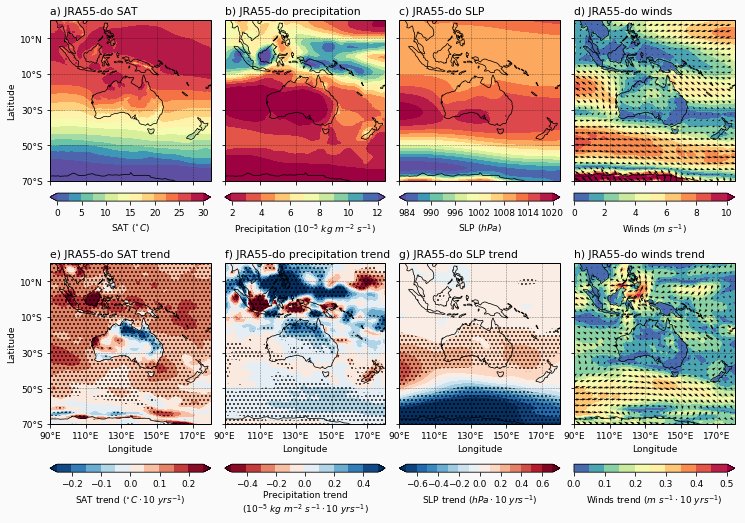

In [11]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
def bbox(pos):
    return matplotlib.transforms.Bbox(np.array([[pos[0],pos[1]],[pos[2],pos[3]]]))
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)

def savefigure(fname):
    output_dir = '/home/561/erd561/figures/Australia/'
    fig_name = nb_name[:-6]
    fig_dir = output_dir + fig_name

    output_ls = os.listdir(output_dir)
    if fig_name not in output_ls:
        os.mkdir(fig_dir) 
    plt.savefig(os.path.join(fig_dir, fig_name[0:4]+fname+'.png'), 
                dpi=300, bbox_inches="tight")


land_50m= cft.NaturalEarthFeature('physical', 'land', '110m',
                                    edgecolor='black',
                                    facecolor='',
                                    linewidth=0.75)

# fig = plt.figure(1, figsize=(8,12), facecolor=[0.98,0.98,0.98]) 
fig = plt.figure(1, figsize=(12,8), facecolor=[0.98,0.98,0.98]) 
matplotlib.rcParams.update({'font.size': 9})    

row=2
col=4

ax = plt.subplot(row, col, 1, projection=ccrs.PlateCarree())
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0, pos.x1+0.0175, pos.y1+0.03] 
print(pos_plot)
levels=arange(0,30,2.5)
cmap = plt.cm.Spectral_r
data = t_10.mean('year') - 273.15
plot = plt.contourf(data.longitude, data.latitude, data,
            cmap=cmap, levels=levels, extend='both', transform=ccrs.PlateCarree())
ax.set_position(bbox(pos_plot))
ax.set_title('a) JRA55-do SAT', loc='left')
ax.set_extent([90, 180, -70, 20], crs=ccrs.PlateCarree())
ax.set_xticks(arange(90, 180, 20), crs=ccrs.PlateCarree())
ax.set_yticks(arange(-70, 20, 20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('Latitude')
# ax.set_yticklabels('')
ax.grid(linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.add_feature(land_50m)
axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.125, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal',
                    label=r'SAT ($^{\circ}C$)', cax=axins)

ax = plt.subplot(row, col, 2, projection=ccrs.PlateCarree())
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0, pos.x1+0.0175, pos.y1+0.03] 
print(pos_plot)
levels=arange(2,12,1)
cmap = plt.cm.Spectral
data = rain.mean('year') * 100000
plot = plt.contourf(data.longitude, data.latitude, data,
            cmap=cmap, levels=levels, extend='both', transform=ccrs.PlateCarree())
ax.set_position(bbox(pos_plot))
ax.set_title('b) JRA55-do precipitation', loc='left')
ax.set_extent([90, 180, -70, 20], crs=ccrs.PlateCarree())
ax.set_xticks(arange(90, 180, 20), crs=ccrs.PlateCarree())
ax.set_yticks(arange(-70, 20, 20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.grid(linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.add_feature(land_50m)
axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.125, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal',
                    label=r'Precipitation ($10^{-5}\ kg\ m^{-2}\ s^{-1}$)', cax=axins)

ax = plt.subplot(row, col, 3, projection=ccrs.PlateCarree())
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0, pos.x1+0.0175, pos.y1+0.03] 
print(pos_plot)
levels=arange(984,1020,3)
cmap = plt.cm.Spectral_r
data = slp.mean('year') /100
plot = plt.contourf(data.longitude, data.latitude, data,
            cmap=cmap, levels=levels, extend='both', transform=ccrs.PlateCarree())
ax.set_position(bbox(pos_plot))
ax.set_title('c) JRA55-do SLP', loc='left')
ax.set_extent([90, 180, -70, 20], crs=ccrs.PlateCarree())
ax.set_xticks(arange(90, 180, 20), crs=ccrs.PlateCarree())
ax.set_yticks(arange(-70, 20, 20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.grid(linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.add_feature(land_50m)
axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.125, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal', ticks=levels[::2],
                    label=r'SLP ($hPa$)', cax=axins)

ax = plt.subplot(row, col, 4, projection=ccrs.PlateCarree())
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0, pos.x1+0.0175, pos.y1+0.03] 
print(pos_plot)
levels=arange(0,10,1)
cmap = plt.cm.Spectral_r
data = (u_10.mean('year')**2 + v_10.mean('year')**2)**(1/2)
plot = plt.contourf(data.longitude, data.latitude, data,
                       cmap=cmap, levels=levels, extend='max', 
                            cbar_kwargs={'orientation':'horizontal'})
u_10_norm = u_10.mean('year') / (u_10.mean('year')**2 + v_10.mean('year')**2)**(1/4)
v_10_norm = v_10.mean('year') / (u_10.mean('year')**2 + v_10.mean('year')**2)**(1/4)
u_10_plot = u_10.mean('year') 
v_10_plot = v_10.mean('year')
n = 6
plt.quiver(u_10_norm.longitude[0:161:n], 
           u_10_norm.latitude[0:161:n], 
           u_10_norm[0:161:n,0:161:n], 
           v_10_norm[0:161:n,0:161:n],
           width=0.005, scale=75)
ax.set_position(bbox(pos_plot))
ax.set_title('d) JRA55-do winds', loc='left')
ax.set_extent([90, 180, -70, 20], crs=ccrs.PlateCarree())
ax.set_xticks(arange(90, 180, 20), crs=ccrs.PlateCarree())
ax.set_yticks(arange(-70, 20, 20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.grid(linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.add_feature(land_50m)
axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.125, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal',
                    label=r'Winds ($m\ s^{-1}$)', cax=axins)

ax = plt.subplot(row, col, 5, projection=ccrs.PlateCarree())
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0-0.01, pos.x1+0.0175, pos.y1+0.02]
print(pos_plot)
levels=arange(-0.25,0.25,0.05)
cmap = plt.cm.RdBu_r
data = t_10_slopes * 10
plot = plt.contourf(data.longitude, data.latitude, data,
            cmap=cmap, levels=levels, extend='both', transform=ccrs.PlateCarree())
levels2=[0, 0.05]
data2 = t_10_p
plot2 = plt.contourf(data.longitude, data.latitude, data2, hatches=['...'],
            colors='none', levels=levels2, transform=ccrs.PlateCarree())
ax.set_position(bbox(pos_plot))
ax.set_title('e) JRA55-do SAT trend', loc='left')
ax.set_extent([90, 180, -70, 20], crs=ccrs.PlateCarree())
ax.set_xticks(arange(90, 180, 20), crs=ccrs.PlateCarree())
ax.set_yticks(arange(-70, 20, 20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlabel('Longitude')
# ax.set_xticklabels('')
ax.set_ylabel('Latitude')
# ax.set_yticklabels('')
ax.grid(linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.add_feature(land_50m)
axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.3, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal',
                    label=r'SAT trend ($^{\circ}C \cdot 10\ yrs^{-1}$)', cax=axins)

ax = plt.subplot(row, col, 6, projection=ccrs.PlateCarree())
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0-0.01, pos.x1+0.0175, pos.y1+0.02]
print(pos_plot)
levels=arange(-0.5,0.5,0.1)
cmap = plt.cm.RdBu
data = rain_slopes * 100000 * 10
plot = plt.contourf(data.longitude, data.latitude, data,
            cmap=cmap, levels=levels, extend='both', transform=ccrs.PlateCarree())
levels2=[0, 0.05]
data2 = rain_p
plot2 = plt.contourf(data.longitude, data.latitude, data2, hatches=['...'],
            colors='none', levels=levels2, transform=ccrs.PlateCarree())
ax.set_position(bbox(pos_plot))
ax.set_title('f) JRA55-do precipitation trend', loc='left')
ax.set_extent([90, 180, -70, 20], crs=ccrs.PlateCarree())
ax.set_xticks(arange(90, 180, 20), crs=ccrs.PlateCarree())
ax.set_yticks(arange(-70, 20, 20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlabel('Longitude')
# ax.set_xticklabels('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.grid(linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.add_feature(land_50m)
axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.3, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal',
                    label='Precipitation trend\n' +\
                    '($10^{-5}\ kg\ m^{-2}\ s^{-1} \cdot 10\ yrs^{-1}$)', cax=axins)

ax = plt.subplot(row, col, 7, projection=ccrs.PlateCarree())
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0-0.01, pos.x1+0.0175, pos.y1+0.02]
print(pos_plot)
levels=arange(-0.7,0.7,0.1)
cmap = plt.cm.RdBu_r
data = slp_slopes / 100 * 10
plot = plt.contourf(data.longitude, data.latitude, data,
            cmap=cmap, levels=levels, extend='both', transform=ccrs.PlateCarree())
levels2=[0, 0.05]
data2 = slp_p
plot2 = plt.contourf(data.longitude, data.latitude, data2, hatches=['...'],
            colors='none', levels=levels2, transform=ccrs.PlateCarree())
ax.set_position(bbox(pos_plot))
ax.set_title('g) JRA55-do SLP trend', loc='left')
ax.set_extent([90, 180, -70, 20], crs=ccrs.PlateCarree())
ax.set_xticks(arange(90, 180, 20), crs=ccrs.PlateCarree())
ax.set_yticks(arange(-70, 20, 20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlabel('Longitude')
# ax.set_xticklabels('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.grid(linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.add_feature(land_50m)
axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.3, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal',
                    label=r'SLP trend ($hPa \cdot 10\ yrs^{-1}$)', cax=axins)

ax = plt.subplot(row, col, 8, projection=ccrs.PlateCarree())
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0-0.01, pos.x1+0.0175, pos.y1+0.02]
print(pos_plot)
levels=arange(0,0.5,0.05)
cmap = plt.cm.Spectral_r
data = ((u_10_slopes*10)**2 + (v_10_slopes*10)**2)**(1/2)
plot = plt.contourf(data.longitude, data.latitude, data,
                       cmap=cmap, levels=levels, extend='max', 
                            cbar_kwargs={'orientation':'horizontal'})
u_10_norm = (u_10_slopes*10) / ((u_10_slopes*10)**2 + (v_10_slopes*10)**2)**(1/4)
v_10_norm = (v_10_slopes*10) / ((u_10_slopes*10)**2 + (v_10_slopes*10)**2)**(1/4)
u_10_plot = (u_10_slopes*10) 
v_10_plot = (v_10_slopes*10)
n = 6
plt.quiver(u_10_norm.longitude[0:161:n], 
           u_10_norm.latitude[0:161:n], 
           u_10_norm[0:161:n,0:161:n], 
           v_10_norm[0:161:n,0:161:n],
           width=0.005, scale=15)
# data2 = temp_z0_p_value_oisst
# plot2 = plt.contourf(data.lon, data.lat, data2, hatches=['...'],
#             colors='none', levels=levels2, transform=ccrs.PlateCarree())
ax.set_position(bbox(pos_plot))
ax.set_title('h) JRA55-do winds trend', loc='left')
ax.set_extent([90, 180, -70, 20], crs=ccrs.PlateCarree())
ax.set_xticks(arange(90, 180, 20), crs=ccrs.PlateCarree())
ax.set_yticks(arange(-70, 20, 20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlabel('Longitude')
# ax.set_xticklabels('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.grid(linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.add_feature(land_50m)
axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.3, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal',
                    label=r'Winds trend ($m\ s^{-1} \cdot 10\ yrs^{-1}$)', cax=axins)

savefigure('forcing_trend_All')

In [1]:
t_10

NameError: name 't_10' is not defined